# Circuit learning module: Lambeq manually with SPSA and JAX

This module performs the optimization of the parametrized circuit manually compared to Lambeq's automatic QuantumTrainer class. I created this because I wanted to have more control over the optimization process and debug it better. The code is based on the workflow presented in https://github.com/CQCL/Quanthoven.

In [1]:
import warnings
import json
import os
import sys
import glob
from math import ceil
from pathlib import Path
from jax import numpy as np
from sympy import default_sort_key
import numpy
import pickle
import matplotlib.pyplot as plt

import jax
from jax import jit
from noisyopt import minimizeSPSA, minimizeCompass

from discopy.quantum import Circuit
from discopy.tensor import Tensor
from discopy.utils import loads
#from pytket.extensions.qiskit import AerBackend
#from pytket.extensions.qulacs import QulacsBackend
#from pytket.extensions.cirq import CirqStateSampleBackend
backend = None

from utils import *
#from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

warnings.filterwarnings('ignore')
this_folder = os.path.abspath(os.getcwd())
os.environ['TOKENIZERS_PARALLELISM'] = 'true'
#os.environ["JAX_PLATFORMS"] = "cpu"

SEED = 0

# This avoids TracerArrayConversionError from jax
Tensor.np = np

rng = numpy.random.default_rng(SEED)
numpy.random.seed(SEED)

## Read circuit data

We read the circuits from the pickled files. Select if we perform binary classification or multi-class classification. Give number of qubits to create classes:
- 1 qubits -> 2^1 = 2 classes i.e. binary classification
- 2 qubits -> 2^2 = 4 classes
- ...
- 5 qubits -> 2^5 = 32 classes, etc.

In [2]:
# Select workload
#workload = "execution_time"
workload = "cardinality"

# Select workload size
#workload_size = "small"
#workload_size = "medium"
#workload_size = "large"
workload_size = "main"

classification = 3
layers = 2
single_qubit_params = 3
n_wire_count = 1

loss = multi_class_loss
acc = multi_class_acc

if classification == 1:
    loss = bin_class_loss
    acc = bin_class_acc

# Access the selected circuits
path_name = this_folder + "//simplified-JOB-diagrams//" + workload + "//" + workload_size + "//circuits//" + str(classification) + "//" + str(layers) + "_layer//" + str(single_qubit_params) + "_single_qubit_params//" + str(n_wire_count) + "_n_wire_count//"

training_circuits_paths = glob.glob(path_name + "training//[0-9]*.p")
validation_circuits_paths = glob.glob(path_name + "validation//[0-9]*.p")
test_circuits_paths = glob.glob(path_name + "test//[0-9]*.p")

In [3]:
training_circuits = read_diagrams(training_circuits_paths)
validation_circuits = read_diagrams(validation_circuits_paths)
test_circuits = read_diagrams(test_circuits_paths)

## Read training and test data

In [4]:
training_data, test_data, validation_data = None, None, None
data_path = this_folder + "//data//" + workload + "//" + workload_size + "//"

with open(data_path + "training_data.json", "r") as inputfile:
    training_data = json.load(inputfile)['training_data']
with open(data_path + "test_data.json", "r") as inputfile:
    test_data = json.load(inputfile)['test_data']
with open(data_path + "validation_data.json", "r") as inputfile:
    validation_data = json.load(inputfile)['validation_data']

training_data_labels = create_labeled_classes(training_data, classification, workload)
test_data_labels = create_labeled_classes(test_data, classification, workload)
validation_data_labels = create_labeled_classes(validation_data, classification, workload)

## Model

In [5]:
def make_pred_fn(circuits):
    # In the case we want to use other backends. 
    # Currently does not work properly.
    if backend:
        compiled_circuits1 = backend.get_compiled_circuits([c.to_tk() for c in circuits])
        circuits = [Circuit.from_tk(c) for c in compiled_circuits1]
        
    circuit_fns = [c.lambdify(*parameters) for c in circuits]
    
    def predict(params):
        outputs = Circuit.eval(*(c(*params) for c in circuit_fns), backend = backend)
        res = []
        
        for output in outputs:
            predictions = np.abs(output.array) + 1e-9
            ratio = predictions / predictions.sum()
            res.append(ratio)
            
        return np.array(res)
    return predict

## Loss function and evaluation

In [6]:
def make_cost_fn(pred_fn, labels):
    def cost_fn(params, **kwargs):
        predictions = pred_fn(params)
        #print(predictions, labels)
        
        cost = loss(predictions, labels) #-np.sum(labels * np.log(predictions)) / len(labels)  # binary cross-entropy loss
        costs.append(cost)

        accuracy = acc(predictions, labels) #np.sum(np.round(predictions) == labels) / len(labels) / 2  # half due to double-counting
        accuracies.append(accuracy)

        return cost

    costs, accuracies = [], []
    return cost_fn, costs, accuracies

## Minimization with noisyopt

In [7]:
def initialize_parameters(old_params, old_values, new_params):
    new_values = list(numpy.array(rng.random(len(new_params))))
    old_param_dict = {}
    for p, v in zip(old_params, old_values):
        old_param_dict[p] = v
        
    parameters = sorted(set(old_params + new_params), key=default_sort_key)
    values = []
    for p in parameters:
        if p in old_param_dict:
            values.append(old_param_dict[p])
        else:
            values.append(new_values.pop())
            
    return parameters, np.array(values)

In [8]:
EPOCHS = 20000
initial_number_of_circuits = 20
syms = {}
limit = False
all_training_keys = list(training_circuits.keys())
initial_circuit_keys = all_training_keys[:initial_number_of_circuits + 1]
current_training_circuits = {}
result_file = workload + "_" + workload_size + "_noisyopt_4_" + str(classification) + "_" + str(layers) + "_" + str(single_qubit_params)

for k in initial_circuit_keys:
    current_training_circuits[k] = training_circuits[k]
    
syms = get_symbols(current_training_circuits)
parameters = sorted(syms, key=default_sort_key)
if initial_number_of_circuits > 20 and os.path.exists("points//" + result_file + ".npz"):
    with open("points//" + result_file + ".npz", "rb") as f:
        print("Loading parameters from file " + result_file)
        npzfile = np.load(f)
        init_params_spsa = npzfile['arr_0']
else:
    print("Initializing new parameters")
    init_params_spsa = np.array(rng.random(len(parameters)))
result = None
run = 0

Initializing new parameters


Progress:  0.045
Number of training circuits: 20   Number of validation circuits: 75   Number of test circuits: 68   Number of parameters in model: 179


Epoch: 200   train/loss: 4.9556   valid/loss: 20.0617   train/acc: 0.05   valid/acc: 0.1067
Epoch: 400   train/loss: 4.6547   valid/loss: 21.2966   train/acc: 0.25   valid/acc: 0.16
Epoch: 600   train/loss: 4.2017   valid/loss: 20.8453   train/acc: 0.4   valid/acc: 0.1467
Epoch: 800   train/loss: 4.1612   valid/loss: 20.1535   train/acc: 0.55   valid/acc: 0.2133
Epoch: 1000   train/loss: 4.9889   valid/loss: 21.1922   train/acc: 0.2   valid/acc: 0.1333
Epoch: 1200   train/loss: 4.5352   valid/loss: 22.3115   train/acc: 0.35   valid/acc: 0.1333
Epoch: 1400   train/loss: 4.283   valid/loss: 21.9307   train/acc: 0.5   valid/acc: 0.2
Epoch: 1600   train/loss: 4.1373   valid/loss: 20.452   train/acc: 0.55   valid/acc: 0.2667
Epoch: 1800   train/loss: 4.0224   valid/loss: 20.0791   train/acc: 0.7   valid/acc: 0.2667
Epoch: 2000   train/loss: 3.9984   valid/loss: 20.66   train/acc: 0.65   valid/acc: 0.2133
Epoch: 2200   train/loss: 3.9782   valid/loss: 20.5091   train/acc: 0.65   valid/acc: 0

Epoch: 18000   train/loss: 3.233   valid/loss: 21.3548   train/acc: 0.5   valid/acc: 0.1733
Epoch: 18200   train/loss: 3.1552   valid/loss: 21.7883   train/acc: 0.4   valid/acc: 0.12
Epoch: 18400   train/loss: 3.3456   valid/loss: 21.6699   train/acc: 0.35   valid/acc: 0.1333
Epoch: 18600   train/loss: 3.1455   valid/loss: 20.0789   train/acc: 0.3   valid/acc: 0.1067
Epoch: 18800   train/loss: 3.1396   valid/loss: 21.3598   train/acc: 0.35   valid/acc: 0.0933
Epoch: 19000   train/loss: 3.1442   valid/loss: 21.207   train/acc: 0.3   valid/acc: 0.16
Epoch: 19200   train/loss: 3.0983   valid/loss: 21.3515   train/acc: 0.5   valid/acc: 0.1867
Epoch: 19400   train/loss: 3.1704   valid/loss: 20.9178   train/acc: 0.4   valid/acc: 0.2
Epoch: 19600   train/loss: 3.1124   valid/loss: 21.4978   train/acc: 0.4   valid/acc: 0.1867
Epoch: 19800   train/loss: 3.1808   valid/loss: 21.5235   train/acc: 0.35   valid/acc: 0.2667
Epoch: 20000   train/loss: 3.2445   valid/loss: 20.7582   train/acc: 0.35   

Test accuracy: 0.19117647058823528
Progress:  0.047
Number of training circuits: 21   Number of validation circuits: 75   Number of test circuits: 68   Number of parameters in model: 179
Progress:  0.049
Number of training circuits: 22   Number of validation circuits: 75   Number of test circuits: 68   Number of parameters in model: 179
Progress:  0.051
Number of training circuits: 23   Number of validation circuits: 76   Number of test circuits: 71   Number of parameters in model: 191
Progress:  0.054
Number of training circuits: 24   Number of validation circuits: 76   Number of test circuits: 71   Number of parameters in model: 191
Progress:  0.056
Number of training circuits: 25   Number of validation circuits: 76   Number of test circuits: 71   Number of parameters in model: 191
Progress:  0.058
Number of training circuits: 26   Number of validation circuits: 78   Number of test circuits: 75   Number of parameters in model: 194
Progress:  0.06
Number of training circuits: 27   Num

Epoch: 200   train/loss: 9.9515   valid/loss: 22.9032   train/acc: 0.0789   valid/acc: 0.1395
Epoch: 400   train/loss: 10.2177   valid/loss: 22.589   train/acc: 0.1053   valid/acc: 0.093
Epoch: 600   train/loss: 9.9701   valid/loss: 24.205   train/acc: 0.1053   valid/acc: 0.1163
Epoch: 800   train/loss: 9.9547   valid/loss: 23.1364   train/acc: 0.0789   valid/acc: 0.1395
Epoch: 1000   train/loss: 9.3036   valid/loss: 23.4625   train/acc: 0.1053   valid/acc: 0.1047
Epoch: 1200   train/loss: 9.8883   valid/loss: 24.0515   train/acc: 0.1842   valid/acc: 0.1395
Epoch: 1400   train/loss: 9.3543   valid/loss: 23.3972   train/acc: 0.1579   valid/acc: 0.1512
Epoch: 1600   train/loss: 10.7249   valid/loss: 23.5271   train/acc: 0.1053   valid/acc: 0.093
Epoch: 1800   train/loss: 9.3916   valid/loss: 22.539   train/acc: 0.2895   valid/acc: 0.1744
Epoch: 2000   train/loss: 8.3302   valid/loss: 21.4532   train/acc: 0.3158   valid/acc: 0.3023
Epoch: 2200   train/loss: 9.3115   valid/loss: 23.38   tr

Epoch: 17600   train/loss: 6.9553   valid/loss: 25.3046   train/acc: 0.3947   valid/acc: 0.186
Epoch: 17800   train/loss: 6.8499   valid/loss: 24.5361   train/acc: 0.3684   valid/acc: 0.1279
Epoch: 18000   train/loss: 7.2576   valid/loss: 24.6986   train/acc: 0.3421   valid/acc: 0.1744
Epoch: 18200   train/loss: 6.9662   valid/loss: 24.3092   train/acc: 0.3947   valid/acc: 0.1744
Epoch: 18400   train/loss: 7.1673   valid/loss: 24.0056   train/acc: 0.4211   valid/acc: 0.1977
Epoch: 18600   train/loss: 7.1216   valid/loss: 23.343   train/acc: 0.4474   valid/acc: 0.1977
Epoch: 18800   train/loss: 7.8392   valid/loss: 22.946   train/acc: 0.3158   valid/acc: 0.1279
Epoch: 19000   train/loss: 7.6464   valid/loss: 24.7527   train/acc: 0.3158   valid/acc: 0.186
Epoch: 19200   train/loss: 7.4899   valid/loss: 23.9769   train/acc: 0.2895   valid/acc: 0.1512
Epoch: 19400   train/loss: 7.6157   valid/loss: 24.5884   train/acc: 0.3947   valid/acc: 0.1977
Epoch: 19600   train/loss: 7.6156   valid/lo

Test accuracy: 0.16279069767441862
Progress:  0.089
Number of training circuits: 39   Number of validation circuits: 86   Number of test circuits: 86   Number of parameters in model: 209
Progress:  0.092
Number of training circuits: 40   Number of validation circuits: 87   Number of test circuits: 86   Number of parameters in model: 212
Progress:  0.094
Number of training circuits: 41   Number of validation circuits: 87   Number of test circuits: 86   Number of parameters in model: 212
Progress:  0.096
Number of training circuits: 42   Number of validation circuits: 87   Number of test circuits: 86   Number of parameters in model: 212
Progress:  0.098
Number of training circuits: 43   Number of validation circuits: 87   Number of test circuits: 88   Number of parameters in model: 215
Progress:  0.1
Number of training circuits: 44   Number of validation circuits: 87   Number of test circuits: 88   Number of parameters in model: 215
Progress:  0.103
Number of training circuits: 45   Numb

Epoch: 200   train/loss: 15.3587   valid/loss: 25.9579   train/acc: 0.1034   valid/acc: 0.1837
Epoch: 400   train/loss: 16.7471   valid/loss: 28.0977   train/acc: 0.0517   valid/acc: 0.0714
Epoch: 600   train/loss: 15.8384   valid/loss: 26.4062   train/acc: 0.1379   valid/acc: 0.1531
Epoch: 800   train/loss: 14.409   valid/loss: 26.4484   train/acc: 0.1207   valid/acc: 0.1122
Epoch: 1000   train/loss: 13.664   valid/loss: 27.5116   train/acc: 0.2069   valid/acc: 0.1735
Epoch: 1200   train/loss: 14.3709   valid/loss: 25.6662   train/acc: 0.1724   valid/acc: 0.0306
Epoch: 1400   train/loss: 13.782   valid/loss: 27.4549   train/acc: 0.2069   valid/acc: 0.1224
Epoch: 1600   train/loss: 13.1536   valid/loss: 27.0221   train/acc: 0.2586   valid/acc: 0.1429
Epoch: 1800   train/loss: 12.9963   valid/loss: 26.1924   train/acc: 0.3448   valid/acc: 0.1224
Epoch: 2000   train/loss: 14.1087   valid/loss: 27.4967   train/acc: 0.1552   valid/acc: 0.0816
Epoch: 2200   train/loss: 14.2858   valid/loss:

Epoch: 17400   train/loss: 11.1765   valid/loss: 27.356   train/acc: 0.431   valid/acc: 0.1122
Epoch: 17600   train/loss: 11.1655   valid/loss: 27.3899   train/acc: 0.4483   valid/acc: 0.1122
Epoch: 17800   train/loss: 11.1522   valid/loss: 27.3892   train/acc: 0.4828   valid/acc: 0.1122
Epoch: 18000   train/loss: 11.143   valid/loss: 27.2276   train/acc: 0.4655   valid/acc: 0.1122
Epoch: 18200   train/loss: 11.1583   valid/loss: 27.3409   train/acc: 0.4483   valid/acc: 0.1122
Epoch: 18400   train/loss: 11.1423   valid/loss: 27.5879   train/acc: 0.4655   valid/acc: 0.102
Epoch: 18600   train/loss: 11.1697   valid/loss: 27.3869   train/acc: 0.4483   valid/acc: 0.0918
Epoch: 18800   train/loss: 11.1532   valid/loss: 27.363   train/acc: 0.5   valid/acc: 0.102
Epoch: 19000   train/loss: 11.1353   valid/loss: 27.2166   train/acc: 0.5   valid/acc: 0.1122
Epoch: 19200   train/loss: 11.124   valid/loss: 27.544   train/acc: 0.5   valid/acc: 0.1122
Epoch: 19400   train/loss: 11.1234   valid/loss

Test accuracy: 0.14285714285714285
Progress:  0.134
Number of training circuits: 59   Number of validation circuits: 98   Number of test circuits: 98   Number of parameters in model: 224
Progress:  0.136
Number of training circuits: 60   Number of validation circuits: 98   Number of test circuits: 98   Number of parameters in model: 224
Progress:  0.138
Number of training circuits: 61   Number of validation circuits: 98   Number of test circuits: 98   Number of parameters in model: 224
Progress:  0.141
Number of training circuits: 62   Number of validation circuits: 98   Number of test circuits: 98   Number of parameters in model: 224
Progress:  0.143
Number of training circuits: 63   Number of validation circuits: 98   Number of test circuits: 98   Number of parameters in model: 224
Progress:  0.145
Number of training circuits: 64   Number of validation circuits: 98   Number of test circuits: 98   Number of parameters in model: 224
Progress:  0.147
Number of training circuits: 65   Nu

Epoch: 200   train/loss: 22.8794   valid/loss: 28.8585   train/acc: 0.0769   valid/acc: 0.13
Epoch: 400   train/loss: 21.3353   valid/loss: 26.9209   train/acc: 0.0769   valid/acc: 0.14
Epoch: 600   train/loss: 20.7599   valid/loss: 27.8095   train/acc: 0.141   valid/acc: 0.12
Epoch: 800   train/loss: 20.3686   valid/loss: 26.3599   train/acc: 0.141   valid/acc: 0.15
Epoch: 1000   train/loss: 21.8648   valid/loss: 28.4006   train/acc: 0.0897   valid/acc: 0.1
Epoch: 1200   train/loss: 19.6492   valid/loss: 27.3926   train/acc: 0.1282   valid/acc: 0.17
Epoch: 1400   train/loss: 19.4262   valid/loss: 27.3174   train/acc: 0.1923   valid/acc: 0.1
Epoch: 1600   train/loss: 19.7737   valid/loss: 27.0689   train/acc: 0.141   valid/acc: 0.2
Epoch: 1800   train/loss: 18.6273   valid/loss: 27.2601   train/acc: 0.2564   valid/acc: 0.12
Epoch: 2000   train/loss: 18.81   valid/loss: 29.1497   train/acc: 0.2179   valid/acc: 0.13
Epoch: 2200   train/loss: 18.7749   valid/loss: 26.9718   train/acc: 0.2

Epoch: 17800   train/loss: 16.0257   valid/loss: 26.228   train/acc: 0.3846   valid/acc: 0.2
Epoch: 18000   train/loss: 15.8375   valid/loss: 26.7685   train/acc: 0.3846   valid/acc: 0.21
Epoch: 18200   train/loss: 15.778   valid/loss: 27.341   train/acc: 0.4487   valid/acc: 0.16
Epoch: 18400   train/loss: 15.7286   valid/loss: 27.5892   train/acc: 0.4231   valid/acc: 0.16
Epoch: 18600   train/loss: 16.6046   valid/loss: 27.1167   train/acc: 0.3846   valid/acc: 0.2
Epoch: 18800   train/loss: 15.9748   valid/loss: 26.3742   train/acc: 0.3333   valid/acc: 0.21
Epoch: 19000   train/loss: 16.0252   valid/loss: 26.9163   train/acc: 0.359   valid/acc: 0.23
Epoch: 19200   train/loss: 15.8588   valid/loss: 26.6147   train/acc: 0.4359   valid/acc: 0.26
Epoch: 19400   train/loss: 16.0175   valid/loss: 26.4555   train/acc: 0.4744   valid/acc: 0.26
Epoch: 19600   train/loss: 16.342   valid/loss: 26.7912   train/acc: 0.4103   valid/acc: 0.22
Epoch: 19800   train/loss: 17.0357   valid/loss: 27.4806 

Test accuracy: 0.21782178217821782
Progress:  0.179
Number of training circuits: 79   Number of validation circuits: 100   Number of test circuits: 101   Number of parameters in model: 233
Progress:  0.181
Number of training circuits: 80   Number of validation circuits: 100   Number of test circuits: 101   Number of parameters in model: 233
Progress:  0.183
Number of training circuits: 81   Number of validation circuits: 100   Number of test circuits: 101   Number of parameters in model: 233
Progress:  0.185
Number of training circuits: 82   Number of validation circuits: 100   Number of test circuits: 101   Number of parameters in model: 233
Progress:  0.188
Number of training circuits: 83   Number of validation circuits: 100   Number of test circuits: 101   Number of parameters in model: 233
Progress:  0.19
Number of training circuits: 84   Number of validation circuits: 100   Number of test circuits: 101   Number of parameters in model: 233
Progress:  0.192
Number of training circui

2023-03-21 18:36:56.739537: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-03-21 18:37:16.751207: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 2m20.01173714s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
Epoch: 200   train/loss: 27.7801   valid/loss: 30.128   train/acc: 0.1837   valid/acc: 0.13
Epoch: 400   train/loss: 26.6956   valid/loss: 27.1497   train/acc: 0.1224   valid/acc: 0.13
Epoch: 600   train/loss: 25.3326   valid/loss: 25.4989   train/acc: 0.2143   valid/acc: 0.14
Epoch: 800   train/loss

Epoch: 16200   train/loss: 20.9445   valid/loss: 26.1724   train/acc: 0.2857   valid/acc: 0.2
Epoch: 16400   train/loss: 22.4412   valid/loss: 26.5123   train/acc: 0.2143   valid/acc: 0.14
Epoch: 16600   train/loss: 22.0853   valid/loss: 27.1563   train/acc: 0.1735   valid/acc: 0.11
Epoch: 16800   train/loss: 21.9846   valid/loss: 26.7017   train/acc: 0.2041   valid/acc: 0.22
Epoch: 17000   train/loss: 21.7789   valid/loss: 26.788   train/acc: 0.2041   valid/acc: 0.15
Epoch: 17200   train/loss: 21.3539   valid/loss: 26.1077   train/acc: 0.2347   valid/acc: 0.23
Epoch: 17400   train/loss: 21.839   valid/loss: 26.1359   train/acc: 0.2041   valid/acc: 0.17
Epoch: 17600   train/loss: 21.4272   valid/loss: 25.5306   train/acc: 0.3265   valid/acc: 0.21
Epoch: 17800   train/loss: 21.6469   valid/loss: 25.6812   train/acc: 0.3265   valid/acc: 0.21
Epoch: 18000   train/loss: 21.287   valid/loss: 24.9677   train/acc: 0.2653   valid/acc: 0.21
Epoch: 18200   train/loss: 20.8442   valid/loss: 26.29

Test accuracy: 0.12871287128712872
Progress:  0.223
Number of training circuits: 99   Number of validation circuits: 100   Number of test circuits: 101   Number of parameters in model: 233
Progress:  0.225
Number of training circuits: 100   Number of validation circuits: 100   Number of test circuits: 101   Number of parameters in model: 233
Progress:  0.228
Number of training circuits: 101   Number of validation circuits: 100   Number of test circuits: 101   Number of parameters in model: 233
Progress:  0.23
Number of training circuits: 102   Number of validation circuits: 100   Number of test circuits: 101   Number of parameters in model: 233
Progress:  0.232
Number of training circuits: 103   Number of validation circuits: 100   Number of test circuits: 101   Number of parameters in model: 233
Progress:  0.234
Number of training circuits: 104   Number of validation circuits: 100   Number of test circuits: 101   Number of parameters in model: 233
Progress:  0.237
Number of training c

2023-03-21 19:21:51.614813: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 2m56.821822952s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
Epoch: 200   train/loss: 31.5515   valid/loss: 28.1461   train/acc: 0.161   valid/acc: 0.09
Epoch: 400   train/loss: 32.8383   valid/loss: 27.6365   train/acc: 0.1271   valid/acc: 0.13
Epoch: 600   train/loss: 31.0758   valid/loss: 26.2854   train/acc: 0.1356   valid/acc: 0.11
Epoch: 800   train/loss: 32.9463   valid/loss: 27.741   train/acc: 0.1186   valid/acc: 0.14
Epoch: 1000   train/loss: 31.3113   valid/loss: 28.4793   train/acc: 0.1525   valid/acc: 0.13
Epoch: 1200   train/loss: 32.3405   valid/loss: 28.6993   train/acc: 0.161   valid/acc: 0.17
Epoch: 1400   train/loss: 31.0678   valid/loss: 26.9674   train/acc: 0.1441

Epoch: 17000   train/loss: 27.6333   valid/loss: 26.3131   train/acc: 0.178   valid/acc: 0.17
Epoch: 17200   train/loss: 27.4809   valid/loss: 26.754   train/acc: 0.2373   valid/acc: 0.12
Epoch: 17400   train/loss: 27.0665   valid/loss: 26.9702   train/acc: 0.2966   valid/acc: 0.13
Epoch: 17600   train/loss: 26.6046   valid/loss: 27.0487   train/acc: 0.339   valid/acc: 0.2
Epoch: 17800   train/loss: 26.8808   valid/loss: 27.9365   train/acc: 0.2712   valid/acc: 0.15
Epoch: 18000   train/loss: 26.5525   valid/loss: 26.9708   train/acc: 0.2458   valid/acc: 0.16
Epoch: 18200   train/loss: 25.8833   valid/loss: 27.4512   train/acc: 0.3475   valid/acc: 0.14
Epoch: 18400   train/loss: 25.6958   valid/loss: 27.8591   train/acc: 0.3644   valid/acc: 0.15
Epoch: 18600   train/loss: 25.592   valid/loss: 27.7269   train/acc: 0.3644   valid/acc: 0.07
Epoch: 18800   train/loss: 25.5292   valid/loss: 27.668   train/acc: 0.3644   valid/acc: 0.17
Epoch: 19000   train/loss: 25.5701   valid/loss: 26.1168

Test accuracy: 0.16831683168316833
Progress:  0.268
Number of training circuits: 119   Number of validation circuits: 100   Number of test circuits: 101   Number of parameters in model: 233
Progress:  0.27
Number of training circuits: 120   Number of validation circuits: 100   Number of test circuits: 101   Number of parameters in model: 233
Progress:  0.272
Number of training circuits: 121   Number of validation circuits: 100   Number of test circuits: 101   Number of parameters in model: 233
Progress:  0.275
Number of training circuits: 122   Number of validation circuits: 100   Number of test circuits: 101   Number of parameters in model: 233
Progress:  0.277
Number of training circuits: 123   Number of validation circuits: 100   Number of test circuits: 101   Number of parameters in model: 233
Progress:  0.279
Number of training circuits: 124   Number of validation circuits: 100   Number of test circuits: 101   Number of parameters in model: 233
Progress:  0.281
Number of training 

2023-03-21 20:14:58.256334: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 3m38.066720927s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-03-21 20:21:26.382663: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-03-21 20:21:28.064077: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 2m1.681444996s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to

Epoch: 15200   train/loss: 33.6839   valid/loss: 27.4025   train/acc: 0.2391   valid/acc: 0.2178
Epoch: 15400   train/loss: 31.3342   valid/loss: 26.5134   train/acc: 0.2899   valid/acc: 0.1188
Epoch: 15600   train/loss: 30.9092   valid/loss: 26.104   train/acc: 0.3333   valid/acc: 0.1782
Epoch: 15800   train/loss: 33.2661   valid/loss: 26.646   train/acc: 0.2319   valid/acc: 0.1584
Epoch: 16000   train/loss: 30.9358   valid/loss: 25.4055   train/acc: 0.2971   valid/acc: 0.099
Epoch: 16200   train/loss: 33.6427   valid/loss: 26.9435   train/acc: 0.2101   valid/acc: 0.1782
Epoch: 16400   train/loss: 33.0139   valid/loss: 27.293   train/acc: 0.2681   valid/acc: 0.198
Epoch: 16600   train/loss: 33.4259   valid/loss: 27.2976   train/acc: 0.2826   valid/acc: 0.1584
Epoch: 16800   train/loss: 32.4405   valid/loss: 26.8233   train/acc: 0.2246   valid/acc: 0.1287
Epoch: 17000   train/loss: 32.348   valid/loss: 27.1395   train/acc: 0.2754   valid/acc: 0.0792
Epoch: 17200   train/loss: 34.9309  

Test accuracy: 0.11650485436893204
Progress:  0.312
Number of training circuits: 139   Number of validation circuits: 101   Number of test circuits: 103   Number of parameters in model: 248
Progress:  0.315
Number of training circuits: 140   Number of validation circuits: 101   Number of test circuits: 103   Number of parameters in model: 248
Progress:  0.317
Number of training circuits: 141   Number of validation circuits: 101   Number of test circuits: 103   Number of parameters in model: 248
Progress:  0.319
Number of training circuits: 142   Number of validation circuits: 101   Number of test circuits: 103   Number of parameters in model: 248
Progress:  0.321
Number of training circuits: 143   Number of validation circuits: 101   Number of test circuits: 103   Number of parameters in model: 248
Progress:  0.324
Number of training circuits: 144   Number of validation circuits: 101   Number of test circuits: 103   Number of parameters in model: 248
Progress:  0.326
Number of training

2023-03-21 21:12:29.325192: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 4m17.912057737s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-03-21 21:18:59.782364: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-03-21 21:19:01.625650: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 2m1.843339521s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to

Epoch: 15200   train/loss: 42.1452   valid/loss: 26.8829   train/acc: 0.121   valid/acc: 0.099
Epoch: 15400   train/loss: 39.6117   valid/loss: 25.9018   train/acc: 0.2357   valid/acc: 0.1485
Epoch: 15600   train/loss: 38.9006   valid/loss: 25.6602   train/acc: 0.1592   valid/acc: 0.1584
Epoch: 15800   train/loss: 38.7752   valid/loss: 26.5406   train/acc: 0.2357   valid/acc: 0.1287
Epoch: 16000   train/loss: 38.0832   valid/loss: 25.7125   train/acc: 0.1975   valid/acc: 0.1386
Epoch: 16200   train/loss: 37.7538   valid/loss: 25.7062   train/acc: 0.1783   valid/acc: 0.1584
Epoch: 16400   train/loss: 40.613   valid/loss: 25.7249   train/acc: 0.1529   valid/acc: 0.1881
Epoch: 16600   train/loss: 37.0116   valid/loss: 25.5141   train/acc: 0.242   valid/acc: 0.1386
Epoch: 16800   train/loss: 37.2844   valid/loss: 26.4495   train/acc: 0.2038   valid/acc: 0.1683
Epoch: 17000   train/loss: 39.5589   valid/loss: 27.2595   train/acc: 0.242   valid/acc: 0.198
Epoch: 17200   train/loss: 39.2759  

Test accuracy: 0.17475728155339806
Progress:  0.357
Number of training circuits: 158   Number of validation circuits: 101   Number of test circuits: 103   Number of parameters in model: 248
Progress:  0.359
Number of training circuits: 159   Number of validation circuits: 101   Number of test circuits: 103   Number of parameters in model: 248
Progress:  0.362
Number of training circuits: 160   Number of validation circuits: 101   Number of test circuits: 103   Number of parameters in model: 248
Progress:  0.364
Number of training circuits: 161   Number of validation circuits: 101   Number of test circuits: 103   Number of parameters in model: 248
Progress:  0.366
Number of training circuits: 162   Number of validation circuits: 101   Number of test circuits: 103   Number of parameters in model: 248
Progress:  0.368
Number of training circuits: 163   Number of validation circuits: 101   Number of test circuits: 103   Number of parameters in model: 248
Progress:  0.371
Number of training

2023-03-21 22:12:47.944929: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-03-21 22:15:45.720967: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 4m57.776129835s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-03-21 22:22:16.294916: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
*

Epoch: 14400   train/loss: 42.4529   valid/loss: 26.4487   train/acc: 0.2542   valid/acc: 0.1485
Epoch: 14600   train/loss: 42.4036   valid/loss: 25.7924   train/acc: 0.2147   valid/acc: 0.1782
Epoch: 14800   train/loss: 42.7211   valid/loss: 26.7657   train/acc: 0.1695   valid/acc: 0.1683
Epoch: 15000   train/loss: 42.7473   valid/loss: 26.8476   train/acc: 0.1864   valid/acc: 0.1386
Epoch: 15200   train/loss: 43.3679   valid/loss: 26.6496   train/acc: 0.1864   valid/acc: 0.1485
Epoch: 15400   train/loss: 43.5911   valid/loss: 26.4686   train/acc: 0.2429   valid/acc: 0.1881
Epoch: 15600   train/loss: 43.7367   valid/loss: 26.5443   train/acc: 0.1638   valid/acc: 0.1683
Epoch: 15800   train/loss: 46.1479   valid/loss: 26.6232   train/acc: 0.1186   valid/acc: 0.099
Epoch: 16000   train/loss: 43.315   valid/loss: 26.6495   train/acc: 0.2316   valid/acc: 0.1683
Epoch: 16200   train/loss: 43.4769   valid/loss: 25.6205   train/acc: 0.1808   valid/acc: 0.0594
Epoch: 16400   train/loss: 46.64

Test accuracy: 0.13592233009708737
Progress:  0.402
Number of training circuits: 178   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 254
Progress:  0.404
Number of training circuits: 179   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 254
Progress:  0.406
Number of training circuits: 180   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 254
Progress:  0.408
Number of training circuits: 181   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 266
Progress:  0.411
Number of training circuits: 182   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 266
Progress:  0.413
Number of training circuits: 183   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 266
Progress:  0.415
Number of training

2023-03-21 23:24:09.456827: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 5m58.653202669s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-03-21 23:31:09.661929: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-03-21 23:31:27.754244: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 2m18.092426575s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_t

Epoch: 15200   train/loss: 47.3096   valid/loss: 28.6705   train/acc: 0.2741   valid/acc: 0.1698
Epoch: 15400   train/loss: 46.8504   valid/loss: 28.6371   train/acc: 0.269   valid/acc: 0.1887
Epoch: 15600   train/loss: 48.0301   valid/loss: 28.4052   train/acc: 0.269   valid/acc: 0.1792
Epoch: 15800   train/loss: 49.0226   valid/loss: 27.1698   train/acc: 0.1574   valid/acc: 0.1509
Epoch: 16000   train/loss: 48.2403   valid/loss: 28.1517   train/acc: 0.2132   valid/acc: 0.1698
Epoch: 16200   train/loss: 49.383   valid/loss: 28.1295   train/acc: 0.2335   valid/acc: 0.1792
Epoch: 16400   train/loss: 47.0644   valid/loss: 27.1221   train/acc: 0.2386   valid/acc: 0.1792
Epoch: 16600   train/loss: 49.0185   valid/loss: 27.6593   train/acc: 0.1878   valid/acc: 0.1415
Epoch: 16800   train/loss: 46.9613   valid/loss: 27.9017   train/acc: 0.2437   valid/acc: 0.1226
Epoch: 17000   train/loss: 47.6481   valid/loss: 27.9962   train/acc: 0.2081   valid/acc: 0.1415
Epoch: 17200   train/loss: 47.722

Test accuracy: 0.19626168224299065
Progress:  0.446
Number of training circuits: 198   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 266
Progress:  0.449
Number of training circuits: 199   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 266
Progress:  0.451
Number of training circuits: 200   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 266
Progress:  0.453
Number of training circuits: 201   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 266
Progress:  0.455
Number of training circuits: 202   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 266
Progress:  0.458
Number of training circuits: 203   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 266
Progress:  0.46
Number of training 

2023-03-22 00:34:47.183708: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-03-22 00:39:39.523672: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 6m52.339900099s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-03-22 00:46:46.059289: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
*

Epoch: 14400   train/loss: 56.9093   valid/loss: 28.1765   train/acc: 0.1244   valid/acc: 0.1132
Epoch: 14600   train/loss: 55.7045   valid/loss: 28.0551   train/acc: 0.1982   valid/acc: 0.1509
Epoch: 14800   train/loss: 54.023   valid/loss: 27.8614   train/acc: 0.1475   valid/acc: 0.1604
Epoch: 15000   train/loss: 53.6994   valid/loss: 27.3588   train/acc: 0.235   valid/acc: 0.1981
Epoch: 15200   train/loss: 53.8929   valid/loss: 28.1324   train/acc: 0.1889   valid/acc: 0.1226
Epoch: 15400   train/loss: 56.0601   valid/loss: 26.7263   train/acc: 0.1475   valid/acc: 0.1792
Epoch: 15600   train/loss: 57.1318   valid/loss: 27.8662   train/acc: 0.1152   valid/acc: 0.1792
Epoch: 15800   train/loss: 56.707   valid/loss: 27.5767   train/acc: 0.1567   valid/acc: 0.1415
Epoch: 16000   train/loss: 55.513   valid/loss: 28.6368   train/acc: 0.1382   valid/acc: 0.0943
Epoch: 16200   train/loss: 55.4082   valid/loss: 27.5632   train/acc: 0.1797   valid/acc: 0.1887
Epoch: 16400   train/loss: 55.0316

Test accuracy: 0.1588785046728972
Progress:  0.491
Number of training circuits: 218   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 278
Progress:  0.493
Number of training circuits: 219   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 278
Progress:  0.496
Number of training circuits: 220   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 278
Progress:  0.498
Number of training circuits: 221   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 278
Progress:  0.5
Number of training circuits: 222   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 278
Progress:  0.502
Number of training circuits: 223   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 278
Progress:  0.504
Number of training ci

2023-03-22 01:54:54.948762: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-03-22 02:00:33.365835: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 7m38.417111154s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-03-22 02:07:40.788716: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
*

Epoch: 14400   train/loss: 58.1465   valid/loss: 28.0795   train/acc: 0.2278   valid/acc: 0.1226
Epoch: 14600   train/loss: 60.4136   valid/loss: 27.5317   train/acc: 0.1646   valid/acc: 0.1509
Epoch: 14800   train/loss: 59.4145   valid/loss: 27.1167   train/acc: 0.1983   valid/acc: 0.1698
Epoch: 15000   train/loss: 59.672   valid/loss: 27.7787   train/acc: 0.1603   valid/acc: 0.1415
Epoch: 15200   train/loss: 59.0188   valid/loss: 27.1595   train/acc: 0.1392   valid/acc: 0.1698
Epoch: 15400   train/loss: 57.8022   valid/loss: 27.3273   train/acc: 0.2321   valid/acc: 0.1887
Epoch: 15600   train/loss: 57.6953   valid/loss: 27.0789   train/acc: 0.2194   valid/acc: 0.1981
Epoch: 15800   train/loss: 59.6907   valid/loss: 27.3512   train/acc: 0.173   valid/acc: 0.1226
Epoch: 16000   train/loss: 59.1386   valid/loss: 28.7842   train/acc: 0.1561   valid/acc: 0.1038
Epoch: 16200   train/loss: 62.1518   valid/loss: 28.0778   train/acc: 0.1224   valid/acc: 0.1038
Epoch: 16400   train/loss: 59.74

Test accuracy: 0.14018691588785046
Progress:  0.536
Number of training circuits: 238   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 278
Progress:  0.538
Number of training circuits: 239   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 278
Progress:  0.54
Number of training circuits: 240   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 278
Progress:  0.542
Number of training circuits: 241   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 278
Progress:  0.545
Number of training circuits: 242   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 278
Progress:  0.547
Number of training circuits: 243   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 278
Progress:  0.549
Number of training 

2023-03-22 03:21:21.444209: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-03-22 03:27:52.480275: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 8m31.03614518s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-03-22 03:35:00.704665: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
**

Epoch: 14400   train/loss: 63.4468   valid/loss: 27.3567   train/acc: 0.1333   valid/acc: 0.1226
Epoch: 14600   train/loss: 63.2663   valid/loss: 26.9631   train/acc: 0.1882   valid/acc: 0.2264
Epoch: 14800   train/loss: 65.8399   valid/loss: 28.3455   train/acc: 0.1373   valid/acc: 0.1415
Epoch: 15000   train/loss: 64.2849   valid/loss: 27.8604   train/acc: 0.149   valid/acc: 0.1415
Epoch: 15200   train/loss: 64.8035   valid/loss: 27.8492   train/acc: 0.1529   valid/acc: 0.1509
Epoch: 15400   train/loss: 61.9605   valid/loss: 26.9399   train/acc: 0.1961   valid/acc: 0.1604
Epoch: 15600   train/loss: 62.3679   valid/loss: 27.1303   train/acc: 0.2275   valid/acc: 0.1887
Epoch: 15800   train/loss: 62.372   valid/loss: 27.304   train/acc: 0.2235   valid/acc: 0.2358
Epoch: 16000   train/loss: 64.1031   valid/loss: 27.8121   train/acc: 0.1686   valid/acc: 0.1887
Epoch: 16200   train/loss: 64.5457   valid/loss: 27.7633   train/acc: 0.1451   valid/acc: 0.1981
Epoch: 16400   train/loss: 63.133

Test accuracy: 0.17757009345794392
Progress:  0.58
Number of training circuits: 256   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 278
Progress:  0.583
Number of training circuits: 257   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 278
Progress:  0.585
Number of training circuits: 258   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 278
Progress:  0.587
Number of training circuits: 259   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 278
Progress:  0.589
Number of training circuits: 260   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 278
Progress:  0.592
Number of training circuits: 261   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 278
Progress:  0.594
Number of training 

2023-03-22 04:57:26.861807: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 9m9.964298778s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-03-22 05:04:36.886216: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-03-22 05:04:59.651968: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 2m22.765827008s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to

Epoch: 15200   train/loss: 66.8019   valid/loss: 27.4206   train/acc: 0.2255   valid/acc: 0.1509
Epoch: 15400   train/loss: 70.036   valid/loss: 27.6108   train/acc: 0.1418   valid/acc: 0.1604
Epoch: 15600   train/loss: 66.8721   valid/loss: 27.4851   train/acc: 0.2   valid/acc: 0.1604
Epoch: 15800   train/loss: 66.2135   valid/loss: 27.5388   train/acc: 0.1745   valid/acc: 0.1792
Epoch: 16000   train/loss: 69.426   valid/loss: 27.6542   train/acc: 0.1236   valid/acc: 0.1509
Epoch: 16200   train/loss: 68.4239   valid/loss: 27.5658   train/acc: 0.1564   valid/acc: 0.1415
Epoch: 16400   train/loss: 68.52   valid/loss: 27.0029   train/acc: 0.16   valid/acc: 0.1604
Epoch: 16600   train/loss: 70.2393   valid/loss: 27.2013   train/acc: 0.1745   valid/acc: 0.2075
Epoch: 16800   train/loss: 70.1417   valid/loss: 27.7986   train/acc: 0.1309   valid/acc: 0.1509
Epoch: 17000   train/loss: 67.9477   valid/loss: 27.2181   train/acc: 0.1891   valid/acc: 0.2075
Epoch: 17200   train/loss: 67.1032   va

Test accuracy: 0.19626168224299065
Progress:  0.625
Number of training circuits: 276   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 278
Progress:  0.627
Number of training circuits: 277   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 278
Progress:  0.629
Number of training circuits: 278   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 278
Progress:  0.632
Number of training circuits: 279   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 278
Progress:  0.634
Number of training circuits: 280   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 278
Progress:  0.636
Number of training circuits: 281   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 278
Progress:  0.638
Number of training

2023-03-22 06:25:03.513821: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-03-22 06:33:04.558953: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 10m1.045105278s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-03-22 06:40:15.826245: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
*

Epoch: 14400   train/loss: 71.1328   valid/loss: 27.6684   train/acc: 0.1797   valid/acc: 0.1792
Epoch: 14600   train/loss: 77.0787   valid/loss: 28.8662   train/acc: 0.1322   valid/acc: 0.1038
Epoch: 14800   train/loss: 75.7977   valid/loss: 29.9196   train/acc: 0.1729   valid/acc: 0.0943
Epoch: 15000   train/loss: 79.639   valid/loss: 29.0422   train/acc: 0.1356   valid/acc: 0.1415
Epoch: 15200   train/loss: 74.0811   valid/loss: 27.2703   train/acc: 0.1729   valid/acc: 0.1226
Epoch: 15400   train/loss: 74.1417   valid/loss: 27.7834   train/acc: 0.1627   valid/acc: 0.1604
Epoch: 15600   train/loss: 74.2532   valid/loss: 27.5539   train/acc: 0.1763   valid/acc: 0.1509
Epoch: 15800   train/loss: 79.3081   valid/loss: 30.2649   train/acc: 0.139   valid/acc: 0.1415
Epoch: 16000   train/loss: 73.1749   valid/loss: 28.2037   train/acc: 0.1831   valid/acc: 0.0943
Epoch: 16200   train/loss: 75.6612   valid/loss: 27.9416   train/acc: 0.1763   valid/acc: 0.1321
Epoch: 16400   train/loss: 80.59

Test accuracy: 0.18691588785046728
Progress:  0.67
Number of training circuits: 296   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 278
Progress:  0.672
Number of training circuits: 297   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 278
Progress:  0.674
Number of training circuits: 298   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 278
Progress:  0.676
Number of training circuits: 299   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 278
Progress:  0.679
Number of training circuits: 300   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 278
Progress:  0.681
Number of training circuits: 301   Number of validation circuits: 106   Number of test circuits: 107   Number of parameters in model: 278
Progress:  0.683
Number of training 

2023-03-22 08:04:38.147186: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-03-22 08:13:26.816971: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 10m48.669763838s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-03-22 08:20:41.694118: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.


Epoch: 14400   train/loss: 80.0628   valid/loss: 27.7999   train/acc: 0.1714   valid/acc: 0.1776
Epoch: 14600   train/loss: 78.6446   valid/loss: 28.4407   train/acc: 0.1556   valid/acc: 0.1589
Epoch: 14800   train/loss: 77.8119   valid/loss: 27.1929   train/acc: 0.181   valid/acc: 0.1402
Epoch: 15000   train/loss: 79.6665   valid/loss: 27.8636   train/acc: 0.1619   valid/acc: 0.1308
Epoch: 15200   train/loss: 82.4592   valid/loss: 27.6219   train/acc: 0.1968   valid/acc: 0.1215
Epoch: 15400   train/loss: 80.2117   valid/loss: 27.76   train/acc: 0.1683   valid/acc: 0.1589
Epoch: 15600   train/loss: 82.2201   valid/loss: 27.9854   train/acc: 0.1302   valid/acc: 0.1776
Epoch: 15800   train/loss: 80.9825   valid/loss: 27.0505   train/acc: 0.1746   valid/acc: 0.215
Epoch: 16000   train/loss: 81.2221   valid/loss: 28.22   train/acc: 0.1651   valid/acc: 0.1589
Epoch: 16200   train/loss: 78.5199   valid/loss: 27.5949   train/acc: 0.2032   valid/acc: 0.1776
Epoch: 16400   train/loss: 78.3811  

Test accuracy: 0.205607476635514
Progress:  0.714
Number of training circuits: 316   Number of validation circuits: 107   Number of test circuits: 107   Number of parameters in model: 281
Progress:  0.717
Number of training circuits: 317   Number of validation circuits: 107   Number of test circuits: 107   Number of parameters in model: 281
Progress:  0.719
Number of training circuits: 318   Number of validation circuits: 107   Number of test circuits: 107   Number of parameters in model: 281
Progress:  0.721
Number of training circuits: 319   Number of validation circuits: 107   Number of test circuits: 107   Number of parameters in model: 281
Progress:  0.723
Number of training circuits: 320   Number of validation circuits: 107   Number of test circuits: 107   Number of parameters in model: 281
Progress:  0.725
Number of training circuits: 321   Number of validation circuits: 107   Number of test circuits: 107   Number of parameters in model: 281
Progress:  0.728
Number of training c

2023-03-22 09:51:31.545135: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-03-22 10:01:21.238273: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 11m49.693144007s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-03-22 10:08:43.891502: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.


Epoch: 14400   train/loss: 88.0835   valid/loss: 28.3266   train/acc: 0.1552   valid/acc: 0.1028
Epoch: 14600   train/loss: 85.7214   valid/loss: 28.5192   train/acc: 0.1701   valid/acc: 0.1402
Epoch: 14800   train/loss: 87.6662   valid/loss: 28.0383   train/acc: 0.1194   valid/acc: 0.1402
Epoch: 15000   train/loss: 88.5257   valid/loss: 28.7113   train/acc: 0.1164   valid/acc: 0.1402
Epoch: 15200   train/loss: 85.3336   valid/loss: 28.0906   train/acc: 0.197   valid/acc: 0.1121
Epoch: 15400   train/loss: 84.4838   valid/loss: 27.584   train/acc: 0.197   valid/acc: 0.2056
Epoch: 15600   train/loss: 86.8501   valid/loss: 28.0802   train/acc: 0.1284   valid/acc: 0.1121
Epoch: 15800   train/loss: 88.483   valid/loss: 28.0905   train/acc: 0.1522   valid/acc: 0.1028
Epoch: 16000   train/loss: 87.6123   valid/loss: 27.8693   train/acc: 0.1075   valid/acc: 0.1402
Epoch: 16200   train/loss: 85.4908   valid/loss: 27.3168   train/acc: 0.1522   valid/acc: 0.215
Epoch: 16400   train/loss: 84.2805 

Test accuracy: 0.10185185185185185
Progress:  0.759
Number of training circuits: 336   Number of validation circuits: 107   Number of test circuits: 108   Number of parameters in model: 284
Progress:  0.761
Number of training circuits: 337   Number of validation circuits: 107   Number of test circuits: 108   Number of parameters in model: 284
Progress:  0.763
Number of training circuits: 338   Number of validation circuits: 107   Number of test circuits: 108   Number of parameters in model: 284
Progress:  0.766
Number of training circuits: 339   Number of validation circuits: 107   Number of test circuits: 108   Number of parameters in model: 284
Progress:  0.768
Number of training circuits: 340   Number of validation circuits: 107   Number of test circuits: 108   Number of parameters in model: 284
Progress:  0.77
Number of training circuits: 341   Number of validation circuits: 107   Number of test circuits: 108   Number of parameters in model: 284
Progress:  0.772
Number of training 

2023-03-22 11:45:36.624636: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-03-22 11:56:15.088853: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 12m38.464313334s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-03-22 12:03:34.714790: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.


Epoch: 14400   train/loss: 88.732   valid/loss: 28.2492   train/acc: 0.1723   valid/acc: 0.1028
Epoch: 14600   train/loss: 95.2236   valid/loss: 30.2874   train/acc: 0.1045   valid/acc: 0.1028
Epoch: 14800   train/loss: 90.809   valid/loss: 27.108   train/acc: 0.1808   valid/acc: 0.1495
Epoch: 15000   train/loss: 91.1748   valid/loss: 27.9415   train/acc: 0.1497   valid/acc: 0.1869
Epoch: 15200   train/loss: 90.9624   valid/loss: 27.5676   train/acc: 0.209   valid/acc: 0.2243
Epoch: 15400   train/loss: 92.0966   valid/loss: 27.6747   train/acc: 0.1554   valid/acc: 0.1776
Epoch: 15600   train/loss: 90.7667   valid/loss: 27.8953   train/acc: 0.1638   valid/acc: 0.1682
Epoch: 15800   train/loss: 92.3157   valid/loss: 27.6446   train/acc: 0.1299   valid/acc: 0.1589
Epoch: 16000   train/loss: 92.5104   valid/loss: 29.157   train/acc: 0.1836   valid/acc: 0.1682
Epoch: 16200   train/loss: 92.7969   valid/loss: 28.871   train/acc: 0.1497   valid/acc: 0.1402
Epoch: 16400   train/loss: 87.8681  

Test accuracy: 0.14814814814814814
Progress:  0.804
Number of training circuits: 355   Number of validation circuits: 107   Number of test circuits: 108   Number of parameters in model: 284
Progress:  0.806
Number of training circuits: 356   Number of validation circuits: 107   Number of test circuits: 108   Number of parameters in model: 284
Progress:  0.808
Number of training circuits: 357   Number of validation circuits: 107   Number of test circuits: 108   Number of parameters in model: 284
Progress:  0.81
Number of training circuits: 358   Number of validation circuits: 107   Number of test circuits: 108   Number of parameters in model: 284
Progress:  0.812
Number of training circuits: 359   Number of validation circuits: 107   Number of test circuits: 108   Number of parameters in model: 284
Progress:  0.815
Number of training circuits: 360   Number of validation circuits: 107   Number of test circuits: 108   Number of parameters in model: 284
Progress:  0.817
Number of training 

2023-03-22 13:44:45.789837: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-03-22 13:56:11.361767: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 13m25.571858666s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-03-22 14:03:42.170501: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.


Epoch: 14400   train/loss: 98.3374   valid/loss: 28.2296   train/acc: 0.1257   valid/acc: 0.1574
Epoch: 14600   train/loss: 98.2821   valid/loss: 29.2161   train/acc: 0.107   valid/acc: 0.0741
Epoch: 14800   train/loss: 99.931   valid/loss: 30.5892   train/acc: 0.1364   valid/acc: 0.0926
Epoch: 15000   train/loss: 98.7111   valid/loss: 28.7639   train/acc: 0.1524   valid/acc: 0.1852
Epoch: 15200   train/loss: 97.7384   valid/loss: 28.2296   train/acc: 0.1417   valid/acc: 0.1389
Epoch: 15400   train/loss: 99.9016   valid/loss: 29.0925   train/acc: 0.1417   valid/acc: 0.0833
Epoch: 15600   train/loss: 98.8132   valid/loss: 29.7124   train/acc: 0.1123   valid/acc: 0.1667
Epoch: 15800   train/loss: 97.5086   valid/loss: 29.0561   train/acc: 0.1604   valid/acc: 0.1204
Epoch: 16000   train/loss: 94.0091   valid/loss: 28.1228   train/acc: 0.1497   valid/acc: 0.1481
Epoch: 16200   train/loss: 98.1648   valid/loss: 28.3911   train/acc: 0.1631   valid/acc: 0.1204
Epoch: 16400   train/loss: 96.45

Test accuracy: 0.09174311926605505
Progress:  0.848
Number of training circuits: 375   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 287
Progress:  0.85
Number of training circuits: 376   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 287
Progress:  0.853
Number of training circuits: 377   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 287
Progress:  0.855
Number of training circuits: 378   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 287
Progress:  0.857
Number of training circuits: 379   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 287
Progress:  0.859
Number of training circuits: 380   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 287
Progress:  0.862
Number of training 

2023-03-22 15:51:00.895895: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-03-22 16:03:25.120313: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 14m24.224331051s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-03-22 16:10:57.204525: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.


Epoch: 14400   train/loss: 101.0324   valid/loss: 28.4441   train/acc: 0.1421   valid/acc: 0.1481
Epoch: 14600   train/loss: 104.5427   valid/loss: 29.1197   train/acc: 0.1548   valid/acc: 0.1389
Epoch: 14800   train/loss: 98.5441   valid/loss: 27.6933   train/acc: 0.1523   valid/acc: 0.1111
Epoch: 15000   train/loss: 98.8785   valid/loss: 27.3039   train/acc: 0.1827   valid/acc: 0.1574
Epoch: 15200   train/loss: 100.6412   valid/loss: 28.372   train/acc: 0.1574   valid/acc: 0.0926
Epoch: 15400   train/loss: 98.0237   valid/loss: 27.1389   train/acc: 0.1802   valid/acc: 0.1759
Epoch: 15600   train/loss: 105.8301   valid/loss: 29.5244   train/acc: 0.1447   valid/acc: 0.1111
Epoch: 15800   train/loss: 104.0131   valid/loss: 28.7606   train/acc: 0.1396   valid/acc: 0.1389
Epoch: 16000   train/loss: 103.1   valid/loss: 28.3088   train/acc: 0.1777   valid/acc: 0.1204
Epoch: 16200   train/loss: 102.118   valid/loss: 28.685   train/acc: 0.1878   valid/acc: 0.1111
Epoch: 16400   train/loss: 10

Test accuracy: 0.1743119266055046
Progress:  0.893
Number of training circuits: 395   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 287
Progress:  0.895
Number of training circuits: 396   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 287
Progress:  0.897
Number of training circuits: 397   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 287
Progress:  0.9
Number of training circuits: 398   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 287
Progress:  0.902
Number of training circuits: 399   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 287
Progress:  0.904
Number of training circuits: 400   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 287
Progress:  0.906
Number of training ci

2023-03-22 18:00:21.547667: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-03-22 18:13:23.458822: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 15m1.911225829s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-03-22 18:20:53.616449: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
*

Epoch: 14400   train/loss: 109.469   valid/loss: 29.4501   train/acc: 0.1622   valid/acc: 0.1667
Epoch: 14600   train/loss: 105.5129   valid/loss: 27.647   train/acc: 0.1816   valid/acc: 0.2037
Epoch: 14800   train/loss: 108.055   valid/loss: 28.8851   train/acc: 0.109   valid/acc: 0.1389
Epoch: 15000   train/loss: 106.5957   valid/loss: 28.4988   train/acc: 0.1453   valid/acc: 0.1759
Epoch: 15200   train/loss: 109.2783   valid/loss: 27.8111   train/acc: 0.155   valid/acc: 0.2407
Epoch: 15400   train/loss: 108.1691   valid/loss: 27.9422   train/acc: 0.1477   valid/acc: 0.2037
Epoch: 15600   train/loss: 112.2042   valid/loss: 28.6586   train/acc: 0.1186   valid/acc: 0.1481
Epoch: 15800   train/loss: 104.3284   valid/loss: 27.8056   train/acc: 0.1695   valid/acc: 0.2037
Epoch: 16000   train/loss: 107.5276   valid/loss: 28.8037   train/acc: 0.1235   valid/acc: 0.1111
Epoch: 16200   train/loss: 109.5678   valid/loss: 28.1897   train/acc: 0.1235   valid/acc: 0.1481
Epoch: 16400   train/loss

Test accuracy: 0.14678899082568808
Progress:  0.938
Number of training circuits: 414   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 287
Progress:  0.94
Number of training circuits: 415   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 287
Progress:  0.942
Number of training circuits: 416   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 287
Progress:  0.944
Number of training circuits: 417   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 287
Progress:  0.946
Number of training circuits: 418   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 287
Progress:  0.949
Number of training circuits: 419   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 287
Progress:  0.951
Number of training 

2023-03-22 20:30:05.465711: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 16m7.916609495s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-03-22 20:37:35.606134: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-03-22 20:38:20.753223: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 2m45.147191877s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_t

Epoch: 15000   train/loss: 115.6911   valid/loss: 29.7757   train/acc: 0.1389   valid/acc: 0.1111
Epoch: 15200   train/loss: 111.9971   valid/loss: 27.9017   train/acc: 0.1065   valid/acc: 0.1296
Epoch: 15400   train/loss: 124.0226   valid/loss: 32.7019   train/acc: 0.081   valid/acc: 0.0741
Epoch: 15600   train/loss: 119.4074   valid/loss: 29.8403   train/acc: 0.1343   valid/acc: 0.0833
Epoch: 15800   train/loss: 114.6682   valid/loss: 27.8999   train/acc: 0.0949   valid/acc: 0.1574
Epoch: 16000   train/loss: 116.0756   valid/loss: 28.5646   train/acc: 0.125   valid/acc: 0.1852
Epoch: 16200   train/loss: 109.1207   valid/loss: 29.204   train/acc: 0.1644   valid/acc: 0.1111
Epoch: 16400   train/loss: 111.8362   valid/loss: 28.175   train/acc: 0.1181   valid/acc: 0.1111
Epoch: 16600   train/loss: 111.7021   valid/loss: 27.9726   train/acc: 0.1204   valid/acc: 0.1296
Epoch: 16800   train/loss: 111.6764   valid/loss: 28.4841   train/acc: 0.1389   valid/acc: 0.1759
Epoch: 17000   train/los

Test accuracy: 0.13761467889908258
Progress:  0.982
Number of training circuits: 433   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 287
Progress:  0.984
Number of training circuits: 434   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 287
Progress:  0.987
Number of training circuits: 435   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 287
Progress:  0.989
Number of training circuits: 436   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 287
Progress:  0.991
Number of training circuits: 437   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 287
Progress:  0.993
Number of training circuits: 438   Number of validation circuits: 108   Number of test circuits: 109   Number of parameters in model: 287
Progress:  0.996
Number of training

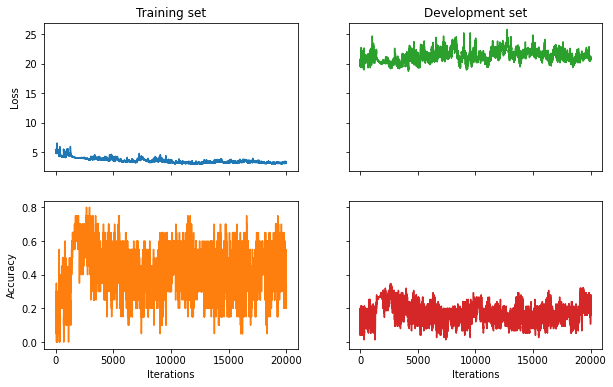

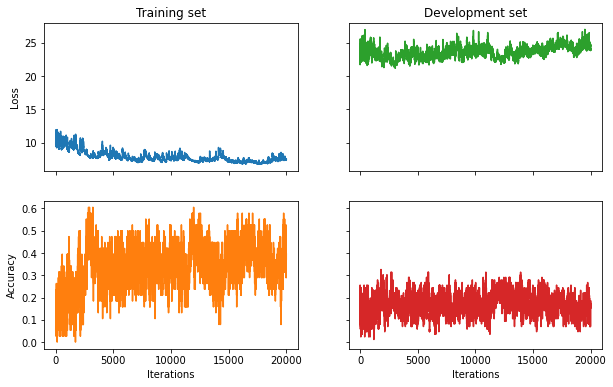

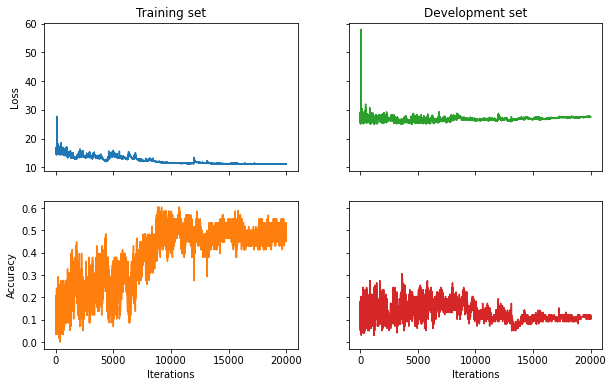

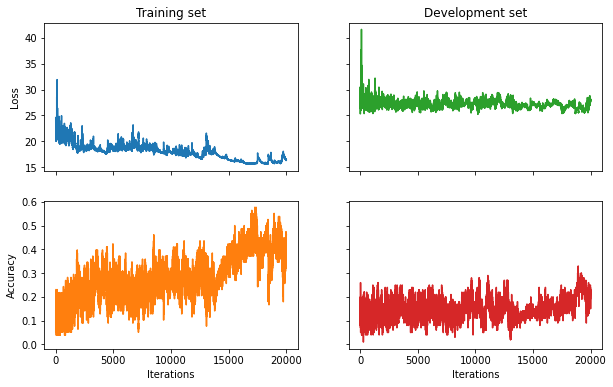

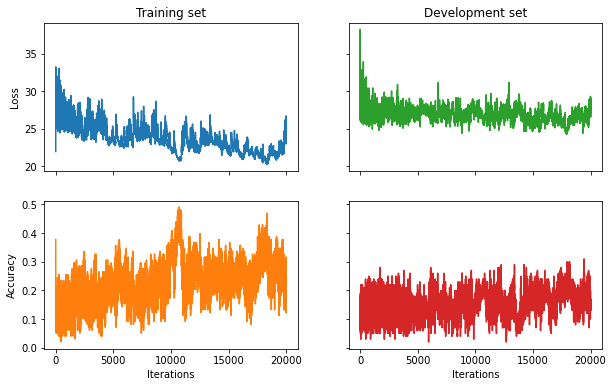

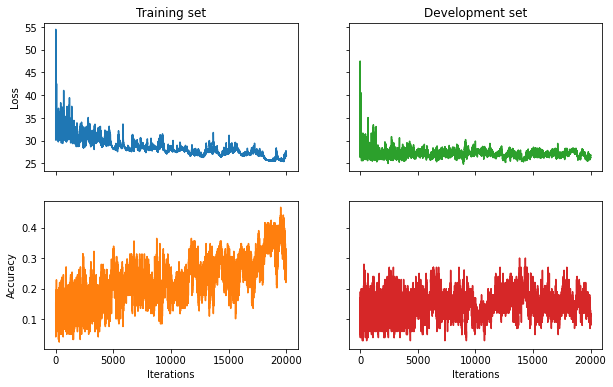

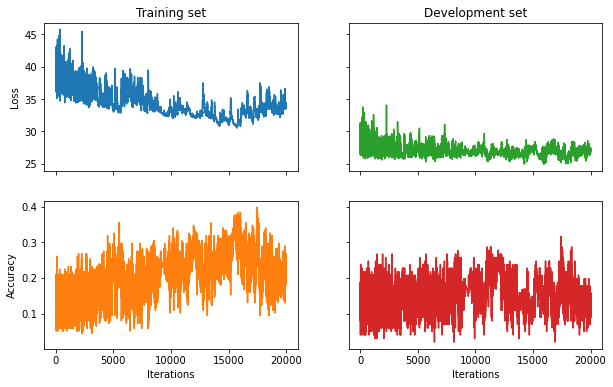

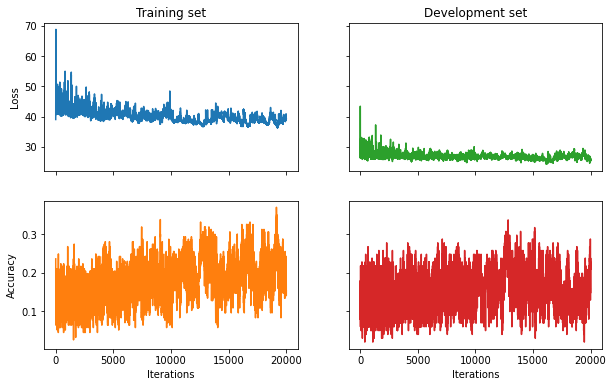

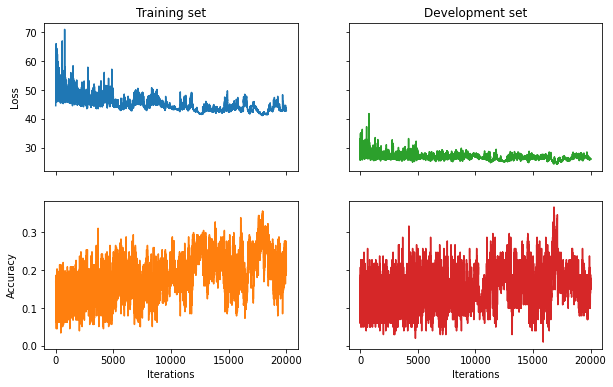

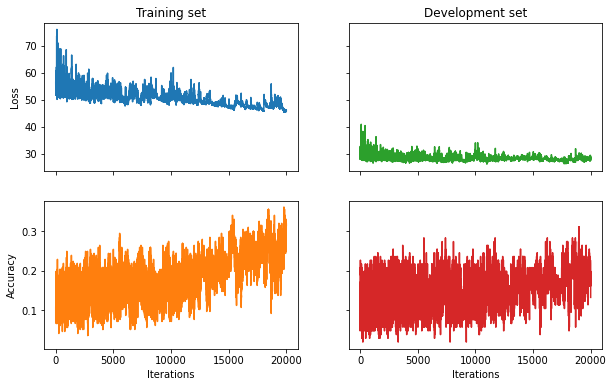

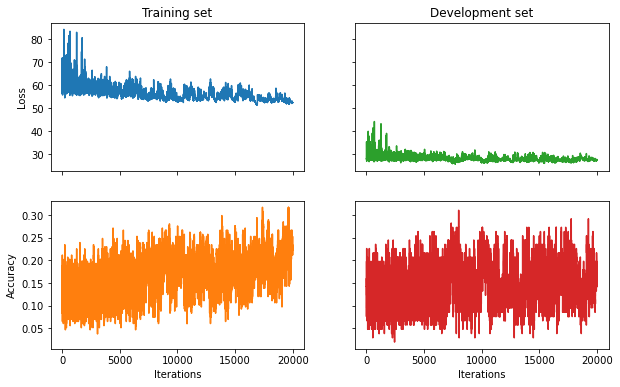

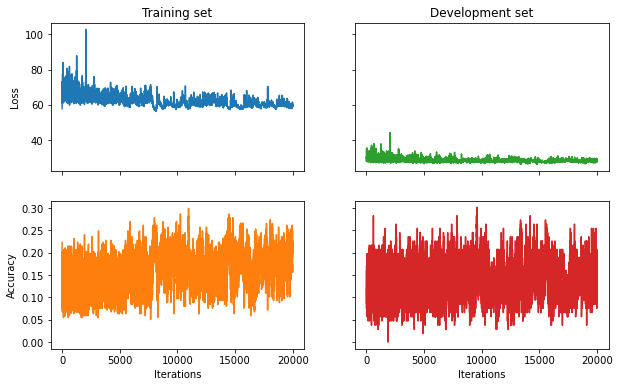

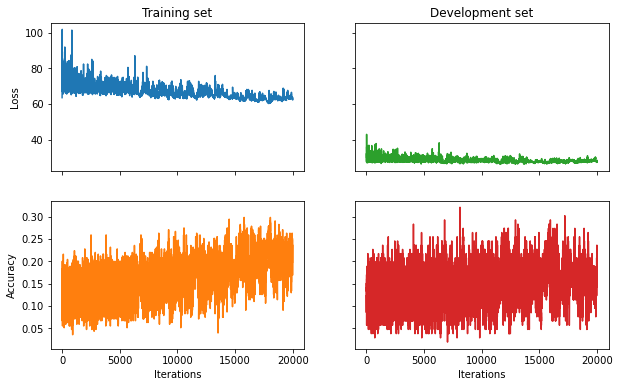

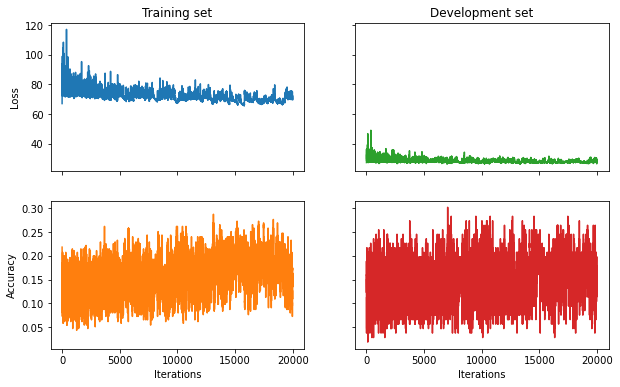

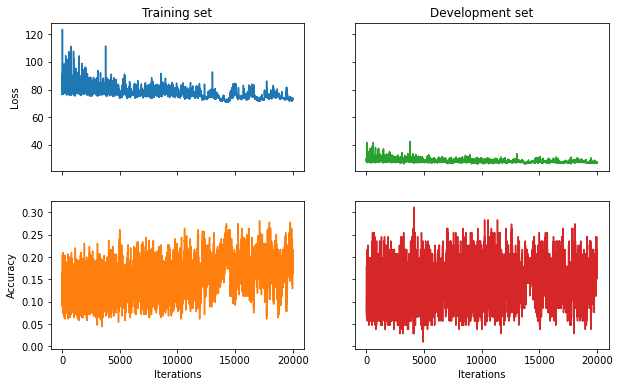

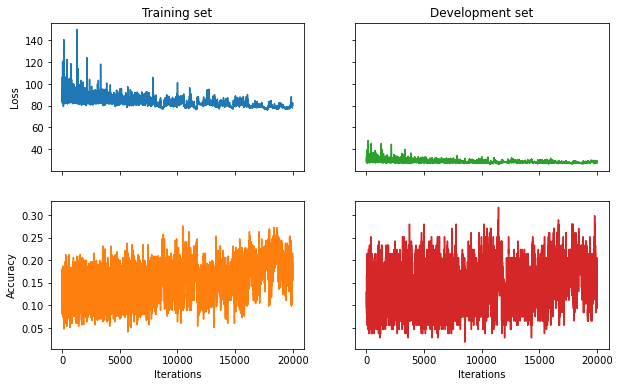

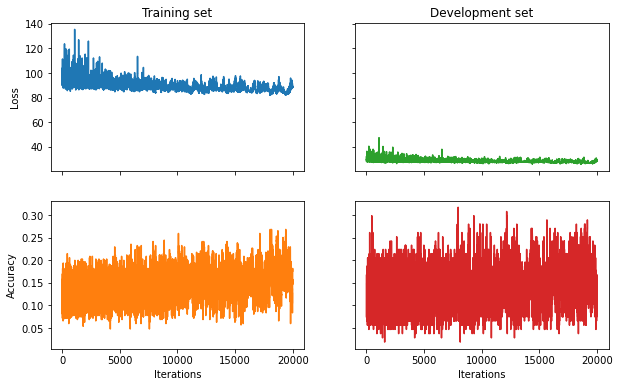

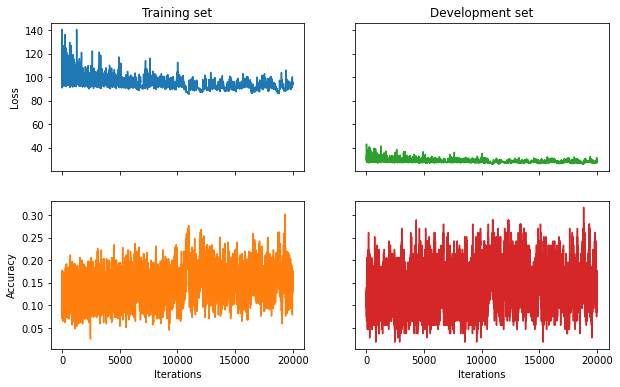

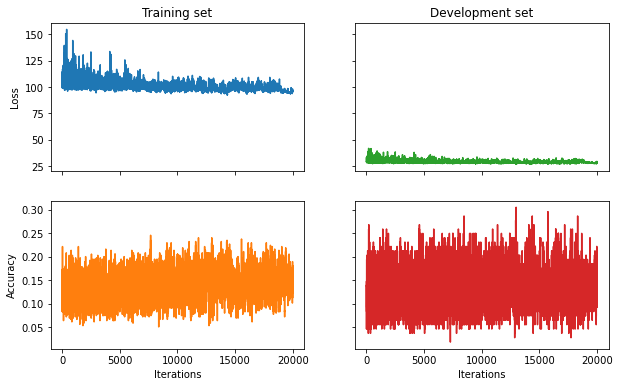

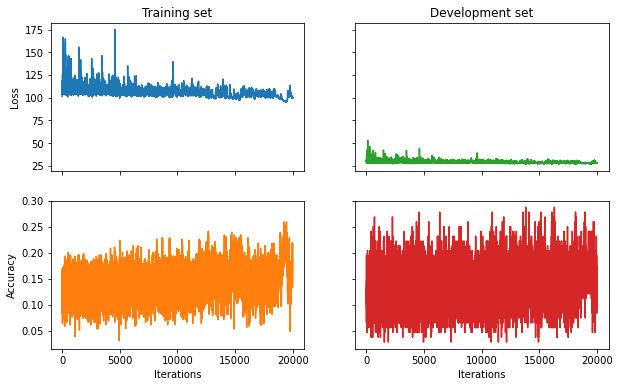

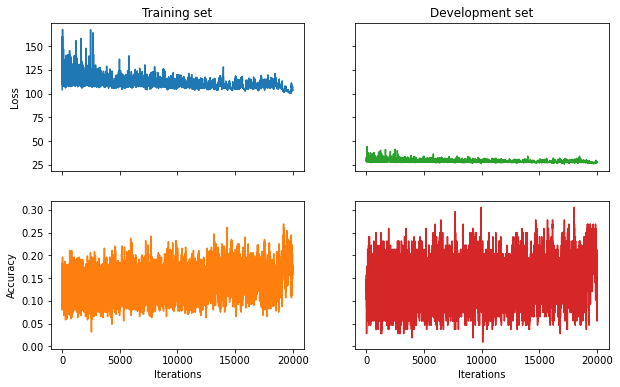

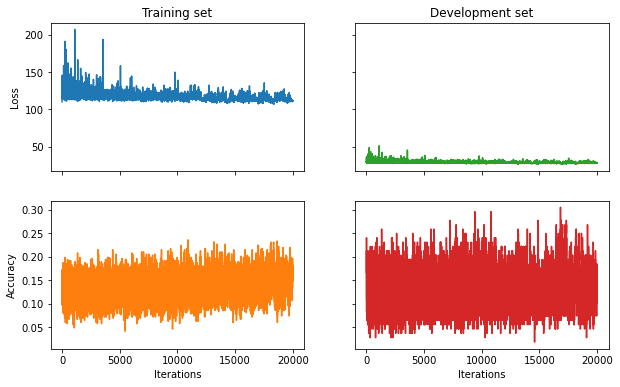

In [9]:
result = None

for i, key in enumerate(all_training_keys[initial_number_of_circuits:]):
    print("Progress: ", round((i + initial_number_of_circuits)/len(all_training_keys), 3))
    
    if len(syms) == len(get_symbols(current_training_circuits)) and i > 0:
        if i != len(all_training_keys[1:]):
            current_training_circuits[key] = training_circuits[key]
            new_parameters = sorted(get_symbols({key: training_circuits[key]}), key=default_sort_key)
            if result:
                parameters, init_params_spsa = initialize_parameters(parameters, result.x, new_parameters)
                #continue
            else:
                syms = get_symbols(current_training_circuits)
                parameters = sorted(syms, key=default_sort_key)
                init_params_spsa = np.array(rng.random(len(parameters)))
    else:
        run += 1
    
    # Select those circuits from test and validation circuits which share the parameters with the current training circuits
    current_validation_circuits = select_circuits(current_training_circuits, validation_circuits)
    current_test_circuits = select_circuits(current_training_circuits, test_circuits)
    
    if len(current_validation_circuits) == 0 or len(current_test_circuits) == 0:
        continue
    
    # Create lists with circuits and their corresponding label
    training_circuits_l, training_data_labels_l = construct_data_and_labels(current_training_circuits, training_data_labels)
    validation_circuits_l, validation_data_labels_l = construct_data_and_labels(current_validation_circuits, validation_data_labels)
    test_circuits_l, test_data_labels_l = construct_data_and_labels(current_test_circuits, test_data_labels)
    
    # Limit the number of validation and test circuits to 20% of number of the training circuits
    if limit:
        val_test_circ_size = ceil(len(current_training_circuits))
        if len(current_validation_circuits) > val_test_circ_size:
            validation_circuits_l = validation_circuits_l[:val_test_circ_size]
            validation_data_labels_l = validation_data_labels_l[:val_test_circ_size]
        if len(current_test_circuits) > val_test_circ_size:
            test_circuits_l = test_circuits_l[:val_test_circ_size]
            test_data_labels_l = test_data_labels_l[:val_test_circ_size]
    
    stats = f"Number of training circuits: {len(training_circuits_l)}   "\
        + f"Number of validation circuits: {len(validation_circuits_l)}   "\
        + f"Number of test circuits: {len(test_circuits_l)}   "\
        + f"Number of parameters in model: {len(set([sym for circuit in training_circuits_l for sym in circuit.free_symbols]))}"
    
    with open("results//" + result_file + ".txt", "a") as f:
        f.write(stats + "\n")
    
    print(stats)
    
    optimization_interval = 20
    
    if result == None or run % optimization_interval == 0:
    
        train_pred_fn = jit(make_pred_fn(training_circuits_l))
        dev_pred_fn = jit(make_pred_fn(validation_circuits_l))
        test_pred_fn = make_pred_fn(test_circuits_l)

        train_cost_fn, train_costs, train_accs = make_cost_fn(train_pred_fn, training_data_labels_l)
        dev_cost_fn, dev_costs, dev_accs = make_cost_fn(dev_pred_fn, validation_data_labels_l)

        def callback_fn(xk):
            #print(xk)
            valid_loss = dev_cost_fn(xk)
            train_loss = numpy.around(min(float(train_costs[-1]), float(train_costs[-2])), 4)
            train_acc = numpy.around(min(float(train_accs[-1]), float(train_accs[-2])), 4)
            valid_acc = numpy.around(float(dev_accs[-1]), 4)
            iters = int(len(train_accs)/2)
            if iters % 200 == 0:
                info = f"Epoch: {iters}   "\
                + f"train/loss: {train_loss}   "\
                + f"valid/loss: {numpy.around(float(valid_loss), 4)}   "\
                + f"train/acc: {train_acc}   "\
                + f"valid/acc: {valid_acc}"

                with open("results//" + result_file + ".txt", "a") as f:
                    f.write(info + "\n")

                print(info, file=sys.stderr)
            return valid_loss

        #a_value = 0.0053
        #c_value = 0.0185

        # Good
        #a_value = 0.053
        #c_value = 0.00185

        #a_value = 0.01
        #c_value = 0.004
        
        #a_values = [1, 0.1, 0.01, 0.001, 0.0001]
        #c_values = [1, 0.1, 0.01, 0.001, 0.0001]
        
        a_value = 0.1 
        c_value = 0.01
        
        train_cost_fn, train_costs, train_accs = make_cost_fn(train_pred_fn, training_data_labels_l)
        dev_cost_fn, dev_costs, dev_accs = make_cost_fn(dev_pred_fn, validation_data_labels_l)
        
        #for a_value in a_values:
        #    for c_value in c_values:
        #        print(a_value, c_value)
        
        result = minimizeSPSA(train_cost_fn, x0=init_params_spsa, a = a_value, c = c_value, niter=EPOCHS, callback=callback_fn)
        #result = minimizeCompass(train_cost_fn, x0=init_params_spsa, redfactor=2.0, deltainit=1.0, deltatol=0.001, feps=1e-15, errorcontrol=True, funcNinit=30, funcmultfactor=2.0, paired=True, alpha=0.05, callback=callback_fn)

        figure_path = this_folder + "//results//" + result_file + ".png"
        visualize_result_noisyopt(result, make_cost_fn, test_pred_fn, test_data_labels_l, train_costs, train_accs, dev_costs, dev_accs, figure_path, result_file)
    
    run += 1
    #EPOCHS += 100
    syms = get_symbols(current_training_circuits)
    
    # Extend for the next optimization round
    current_training_circuits[key] = training_circuits[key]
    new_parameters = sorted(get_symbols({key: training_circuits[key]}), key=default_sort_key)
    parameters, init_params_spsa = initialize_parameters(parameters, result.x, new_parameters)